# Variational Auto-Encoder Generated Problems

Auto-Encoder code adapted from https://github.com/atinghosh/VAE-pytorch

In [1]:
import json
import pandas as pd
import numpy as np
import re
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In [2]:
# Read data from file:
with open('problems.json', 'r') as fp:
    problems_dict = json.load(fp)

In [3]:
# Process data
df = pd.DataFrame.from_dict(problems_dict, orient = 'index')
df.isna().sum()

problem_name     0
info             0
url              0
moves           22
dtype: int64

In [4]:
df = df.dropna()

In [5]:
def move_coordinate(d):
    # convert a move to the coorindates of the hold on the board
    s_split = re.split('(\d+)', d['Description'], maxsplit=1)
    # extra `-1` in both for 0 indexing
    w = ord(s_split[0].upper()) - 64 - 1
    h = int(s_split[1]) - 1
    
    return (h, w, 0)


def convert_moves(moves):
    array = np.zeros((18, 11, 1))
    for move in moves:
        array[move_coordinate(move)] = 1
    return array


df['Moves_array'] = df['moves'].apply(convert_moves)
problems = list(df['Moves_array'])
len(problems)

14902

In [6]:
problems = np.moveaxis(problems, -1, 1)
problems = problems.astype(np.float32)


In [7]:
# Process labels
grades = []
for problem in df['info']:
    grades.append(problem[2])
    
grade_map = {
        '5+':0,
        '6A': 1,
        '6A+': 2,
        '6B': 3,
        '6B+': 4,
        '6C': 5,
        '6C+': 6,
        '7A': 7,
        '7A+': 8,
        '7B': 9,
        '7B+': 10,
        '7C': 11,
        '7C+': 12,
        '8A': 13,
        '8A+': 14,
        '8B': 15,
        '8B+': 16,
        '8C': 17,
        '8C+': 18
    }

grades = [grade.split()[0] for grade in grades]
grades = [grade_map[grade] for grade in grades]
len(grades)

14902

In [8]:
class ProblemDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.transform = transform
        self.label = label
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image_tensor = torch.from_numpy(image)
        
        
        
        
            
        label = self.label[idx]
        
        
        target = torch.tensor(label,dtype=torch.long)
        
        return image_tensor, target

In [9]:
X_train, X_test, y_train, y_test = train_test_split(problems, grades, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


In [10]:
train = ProblemDataset(X_train, y_train)
val = ProblemDataset(X_val, y_val)
test = ProblemDataset(X_test, y_test)

In [11]:
batch_size = 128

In [12]:
train_loader = DataLoader(train, batch_size=16)
val_loader = DataLoader(val, batch_size=16)
test_loader = DataLoader(test, batch_size=16)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


# changed configuration to this instead of argparse for easier interaction
CUDA = True
SEED = 1
BATCH_SIZE = 16
LOG_INTERVAL = 10
EPOCHS = 100
no_of_sample = 10

# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20
ZDIMS = 20

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)






class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4, 4), padding=(10, 7),
                               stride=2)  # This padding keeps the size of the image same, i.e. same padding
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), padding=(10, 7), stride=2)
        self.fc11 = nn.Linear(in_features=128 * 18 * 11, out_features=1024)
        self.fc12 = nn.Linear(in_features=1024, out_features=ZDIMS)

        self.fc21 = nn.Linear(in_features=128 * 18 * 11, out_features=1024)
        self.fc22 = nn.Linear(in_features=1024, out_features=ZDIMS)
        self.relu = nn.ReLU()

        # For decoder

        # For mu
        self.fc1 = nn.Linear(in_features=20, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=7 * 7 * 128)
        self.conv_t1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, padding=1, stride=2)
        self.conv_t2 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(7,2), padding=(1,2), stride=1)



    def encode(self, x: Variable) -> (Variable, Variable):

        x = x.view(-1, 1, 18, 11)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = x.view(-1, 128 * 18 * 11)

        mu_z = F.elu(self.fc11(x))
        mu_z = self.fc12(mu_z)

        logvar_z = F.elu(self.fc21(x))
        logvar_z = self.fc22(logvar_z)

        return mu_z, logvar_z


    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:


        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation

            sample_z = []
            for _ in range(no_of_sample):
                std = logvar.mul(0.5).exp_()  # type: Variable
                eps = Variable(std.data.new(std.size()).normal_())
                sample_z.append(eps.mul(std).add_(mu))

            return sample_z

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z: Variable) -> Variable:

        x = F.elu(self.fc1(z))
        x = F.elu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = F.relu(self.conv_t1(x))
        x = F.sigmoid(self.conv_t2(x))
        return x.view(-1, 198)


    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 198))
        z = self.reparameterize(mu, logvar)
        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar
        # return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar) -> Variable:
        # how well do input x and output recon_x agree?

        if self.training:
            BCE = 0
            for recon_x_one in recon_x:
                BCE += F.binary_cross_entropy(recon_x_one, x.view(-1, 198))
            BCE /= len(recon_x)
        else:
            BCE = F.binary_cross_entropy(recon_x, x.view(-1, 198))

        # KLD is Kullback–Leibler divergence -- how much does one learned
        # distribution deviate from another, in this specific case the
        # learned distribution from the unit Gaussian

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # note the negative D_{KL} in appendix B of the paper
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= BATCH_SIZE * 198


        return BCE + KLD


model = VAE()
if CUDA:
    model.cuda()





optimizer = optim.Adam(model.parameters(), lr=1e-4)


def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = model.loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += model.loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
            n = min(data.size(0), 8)
            # for the first 128 batch of the epoch, show the first 8 input digits
            # with right below them the reconstructed output digits
            comparison = torch.cat([data[:n],
                                    recon_batch.view(BATCH_SIZE, 1, 18, 11)[:n]])
            save_image(comparison.data.cpu(),
                       'reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(1, EPOCHS + 1):
        train(epoch)
        test(epoch)

        # 64 sets of random ZDIMS-float vectors
        sample = Variable(torch.randn(64, ZDIMS))
        if CUDA:
            sample = sample.cuda()
        sample = model.decode(sample).cpu()

        # save out as an 8x8 matrix of generated problems
        # this will give you a visual idea of how well latent space can generate things
        # that look like problems
        save_image(sample.data.view(64, 1, 18, 11),'reconstruction' + str(epoch) + '.png')

## Show an image of a generated problem

In [42]:
sample = Variable(torch.randn(1, ZDIMS))
if CUDA:
    sample = sample.cuda()
sample = model.decode(sample).cpu()

        # save out as an 8x8 matrix of MNIST digits
        # this will give you a visual idea of how well latent space can generate things
        # that look like digits
save_image(sample.data.view(1, 1, 18, 11),'test' + str(epoch) + '.png')

In [72]:
pic = sample.data[0].view(18,11).numpy()
pic2 = np.flipud(pic)

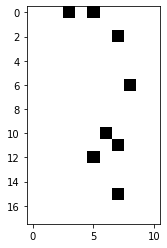

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(pic2>0.21, cmap='gray_r')
plt.show()